# Revisiting MLE

As you recall, for linear regressions, we estimate parameters by deploying some kind of least square technique, the usual suspect being the ordinary least squares (OLS). However, a logistic regression breaks one of the cardinal assumptions of OLS, namely the normality of the target (dependent) variable, given the fact that logistics are binary. 

Therefore, you'll recall that we have to deploy the apparatus of the MLE to do parameter estimation for the right-hand side of the equation. Recall that MLE seek to find the maximum probability given the data at hand. 

# Constructing the Logistic Regression 

As you recall, MLE's require a few ingredients, one is a well-defined likelihood function. Given, the fact that we are dealing with binary targets, we can easily model these using Bernoulli scheme: $$ P(x_i)^{r_i}(1-P(x_i)^{1-r_i})$$

Recall also that we seek to maximize the following: $$\prod_{i=1}^n P(x_i)^{r_i}(1-P(x_i)^{1-r_i})$$ yet because off the annoying property of computing the derivatives numerically, it's best to transform this with the logarithm, which makes this into computing a derivative of a product chain to computing a derivative of a sum: $$\sum_{i=1}^n [r_i * ln(P(x_i)) + (1-r_i)ln(1-P(x_i))]$$

A much "cleaner" functional form with respect to computing a derivative. From here, the problem is transferred to solving a constraint optimization problem. Rarely will you have to do this by hand, and we did some simple finger exercises previously for you to get the feel of it, but in general, the software will handle these in the background for you.

For those of you with the mathematical background, you should check up iterative numerical methods for least square problems.


# Reintroducing the Polling data

This case study will be based off of the data we used in Lab 1.4: http://www.stat.columbia.edu/~gelman/arm/examples/election88/, from the great one, Dr. Gelman, one of the foremost researchers in Bayesian analysis.
Recall, this election was ultimately a major victory for the Grand Old Party (GOP/Republicans), and propelled George H.W. Bush (the father of George W. Bush) into the presidency.
Import the data, and delete the Unnamed column

#### Problem 1

Load the data and check the first few observations to get a view of the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
%matplotlib inline
%precision 4

df = pd.read_csv('../../DSI-CHI-1/lessons/week-08/2.2-linear-regression-with-bayes/assets/datasets/polls.csv', index_col=0)
df.head()

,org,year,survey,bush,state,edu,age,female,black,weight
1,cbsnyt,1,9152,1.0,7,2,2,1,0,1403
2,cbsnyt,1,9152,1.0,33,4,3,0,0,778
3,cbsnyt,1,9152,0.0,20,2,1,1,0,1564
4,cbsnyt,1,9152,1.0,31,3,2,1,0,1055
5,cbsnyt,1,9152,1.0,18,3,1,1,0,1213


Make sure you have the same length of the data set (you will) so you know the file hasn't changed (at least with respect to length). 

In [2]:
df.shape

(13544, 10)

## Model a Logistic Regression Using PyMC

What we're interested in now is to create a Bayesian Logistic Regression that predicts whether Bush would win a given state or not using PyMC

Unsurprisingly, our first step is to set up a model and fit it. You may run into a `Theano` lock error if you still have one of your notebooks open from before. From the notebook selection screen, click any notebooks that are currently running and shut them down to continue.

We'll start by doing a simple model of female and black voters on Bush voteshare:

In [3]:
with pm.Model() as logistic_model:
    pm.glm.glm('bush ~ female + black', df, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)

Applied logodds-transform to p and added transformed p_logodds_ to model.
100%|██████████| 2000/2000 [00:39<00:00, 50.97it/s]


Now, let's output the summary and a traceplot to confirm a good fit:

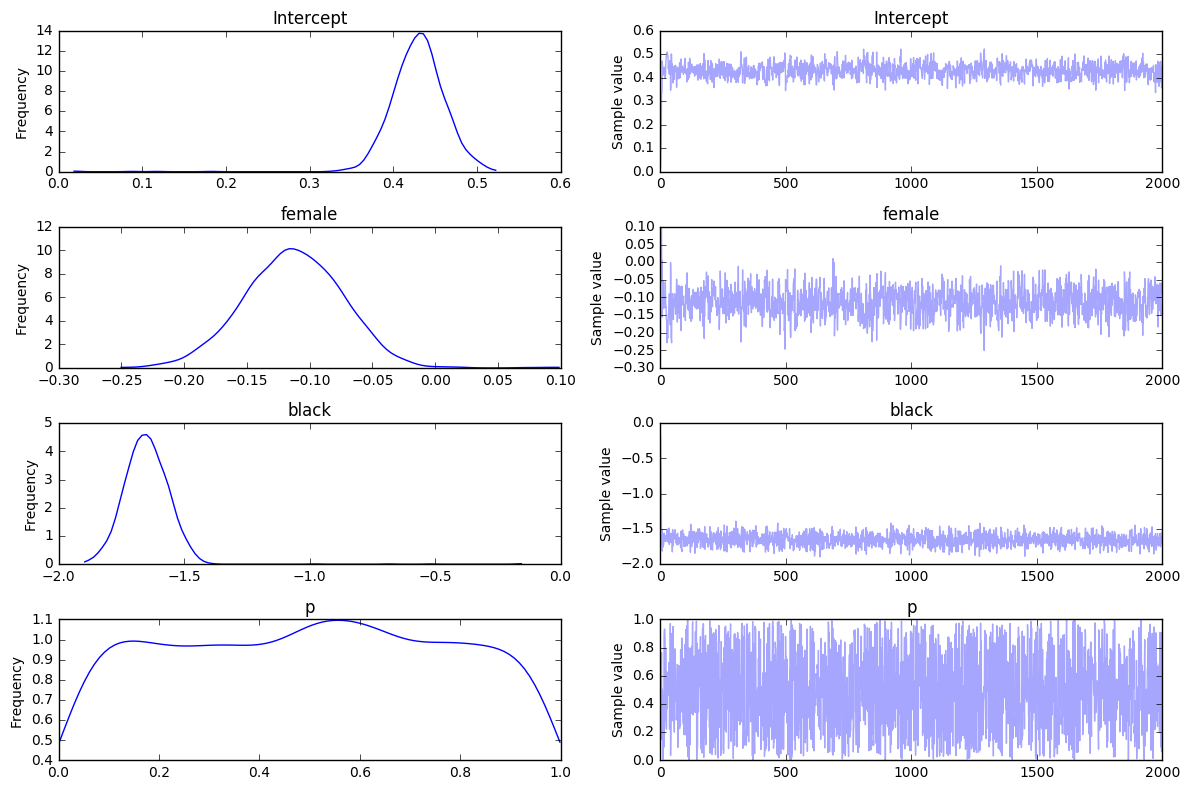

In [4]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace_logistic_model)
plt.tight_layout()

In [5]:
pm.summary(trace_logistic_model)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.430            0.034            0.001            [0.371, 0.489]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.372          0.411          0.431          0.449          0.492


female:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.113           0.040            0.001            [-0.190, -0.040]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.190         -0.139         -0.113         -0.086         -0.039


black:

  Mean             SD               MC Error         95% HPD interval
  -----------------

Build a scatter plot view of the traceplot of the parameters. We can call each of them through the following:

In [6]:
trace_logistic_model['Intercept']

array([ 0.0184,  0.0184,  0.0879, ...,  0.3571,  0.3727,  0.4219])

In [7]:
trace_logistic_model['black']

array([-0.1562, -0.1562, -0.516 , ..., -1.646 , -1.694 , -1.5422])

In [8]:
trace_logistic_model['female']

array([ 0.0198,  0.0198,  0.0698, ..., -0.0599, -0.0877, -0.0591])

In [9]:
def plot_findings(trace, x_axis, y_axis):
    x = trace[x_axis]
    y = trace[y_axis]
    plt.scatter(x, y)
    plt.xlabel('%s estimates' % x_axis)
    plt.ylabel('%s estimates' % y_axis)
    plt.show()

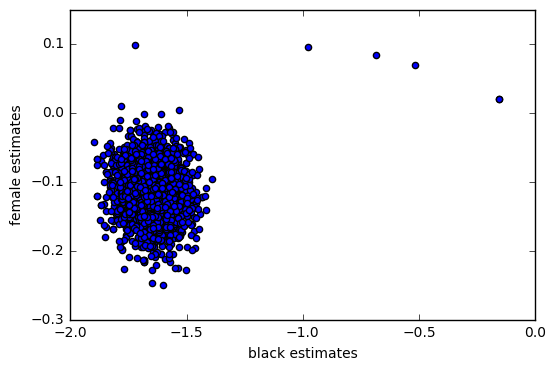

In [10]:
plot_findings(trace_logistic_model, 'black', 'female')

We may also want to make use of seaborn's `jointplot` functionality to give us a more granular look at distribution:

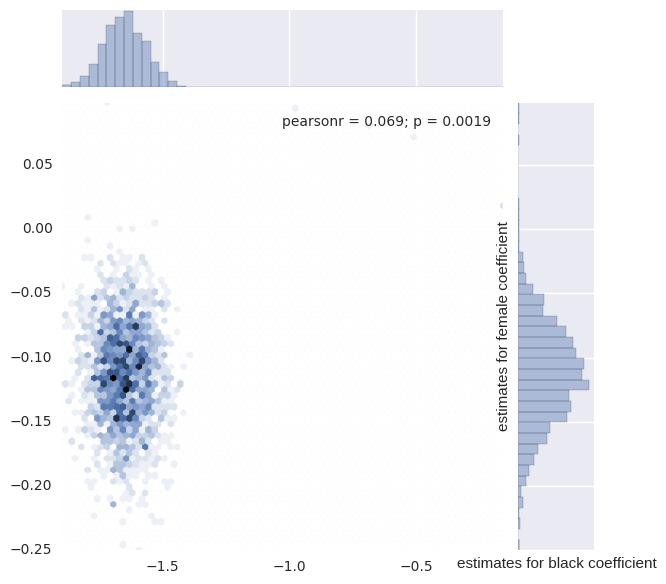

In [11]:
import seaborn as sns

sns.jointplot(trace_logistic_model['black'], trace_logistic_model['female'], kind="hex")
plt.xlabel('estimates for black coefficient')
plt.ylabel('estimates for female coefficient')
plt.show()

Because PyMC is going to lack the nice `predict` function that we've come to expect from sklearn, we'll have to make one ourselves by extracting the coefficients that have been found and defining them ourselves in a function:

In [15]:
def predict_indiv_model(black, female):
    # Returns a series of numbers between 0 and 1 for each run of logistic model
    return 1 / (1 + np.exp(-(trace_logistic_model['Intercept'] +
                        (trace_logistic_model['black'] * black) + 
                        (trace_logistic_model['female'] * female))))

In [16]:
def plot_results(y_series):
    plt.scatter(np.linspace(0, len(y_series), len(y_series)), 
               y_series)
    plt.hlines(y_series.mean(), 0, len(y_series))
    plt.xlabel('Model iteration')
    plt.ylabel('P(Y = 1)')
    plt.show()

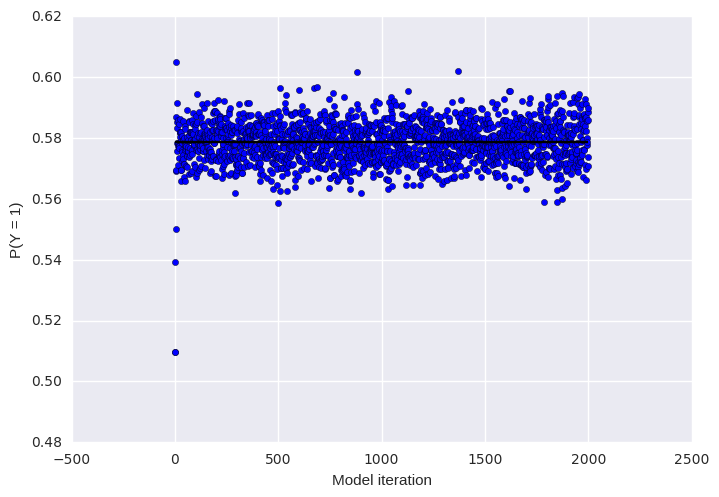

In [17]:
plot_results(predict_indiv_model(0, 1))

Let's redo with the fully-fit model!

In [18]:
df.head()

,org,year,survey,bush,state,edu,age,female,black,weight
1,cbsnyt,1,9152,1.0,7,2,2,1,0,1403
2,cbsnyt,1,9152,1.0,33,4,3,0,0,778
3,cbsnyt,1,9152,0.0,20,2,1,1,0,1564
4,cbsnyt,1,9152,1.0,31,3,2,1,0,1055
5,cbsnyt,1,9152,1.0,18,3,1,1,0,1213


In [20]:
df = df.join(pd.get_dummies(df['edu'], prefix='edu'))

In [21]:
df = df.join(pd.get_dummies(df['age'], prefix='age'))

In [22]:
df.head()

,org,year,survey,bush,state,edu,age,female,black,weight,edu_1,edu_2,edu_3,edu_4,age_1,age_2,age_3,age_4
1,cbsnyt,1,9152,1.0,7,2,2,1,0,1403,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,cbsnyt,1,9152,1.0,33,4,3,0,0,778,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,cbsnyt,1,9152,0.0,20,2,1,1,0,1564,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,cbsnyt,1,9152,1.0,31,3,2,1,0,1055,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,cbsnyt,1,9152,1.0,18,3,1,1,0,1213,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [24]:
with pm.Model() as logistic_model:
    pm.glm.glm('bush ~ female + black + age_1 + age_2', df, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)

Applied logodds-transform to p and added transformed p_logodds_ to model.
100%|██████████| 2000/2000 [00:48<00:00, 41.52it/s]


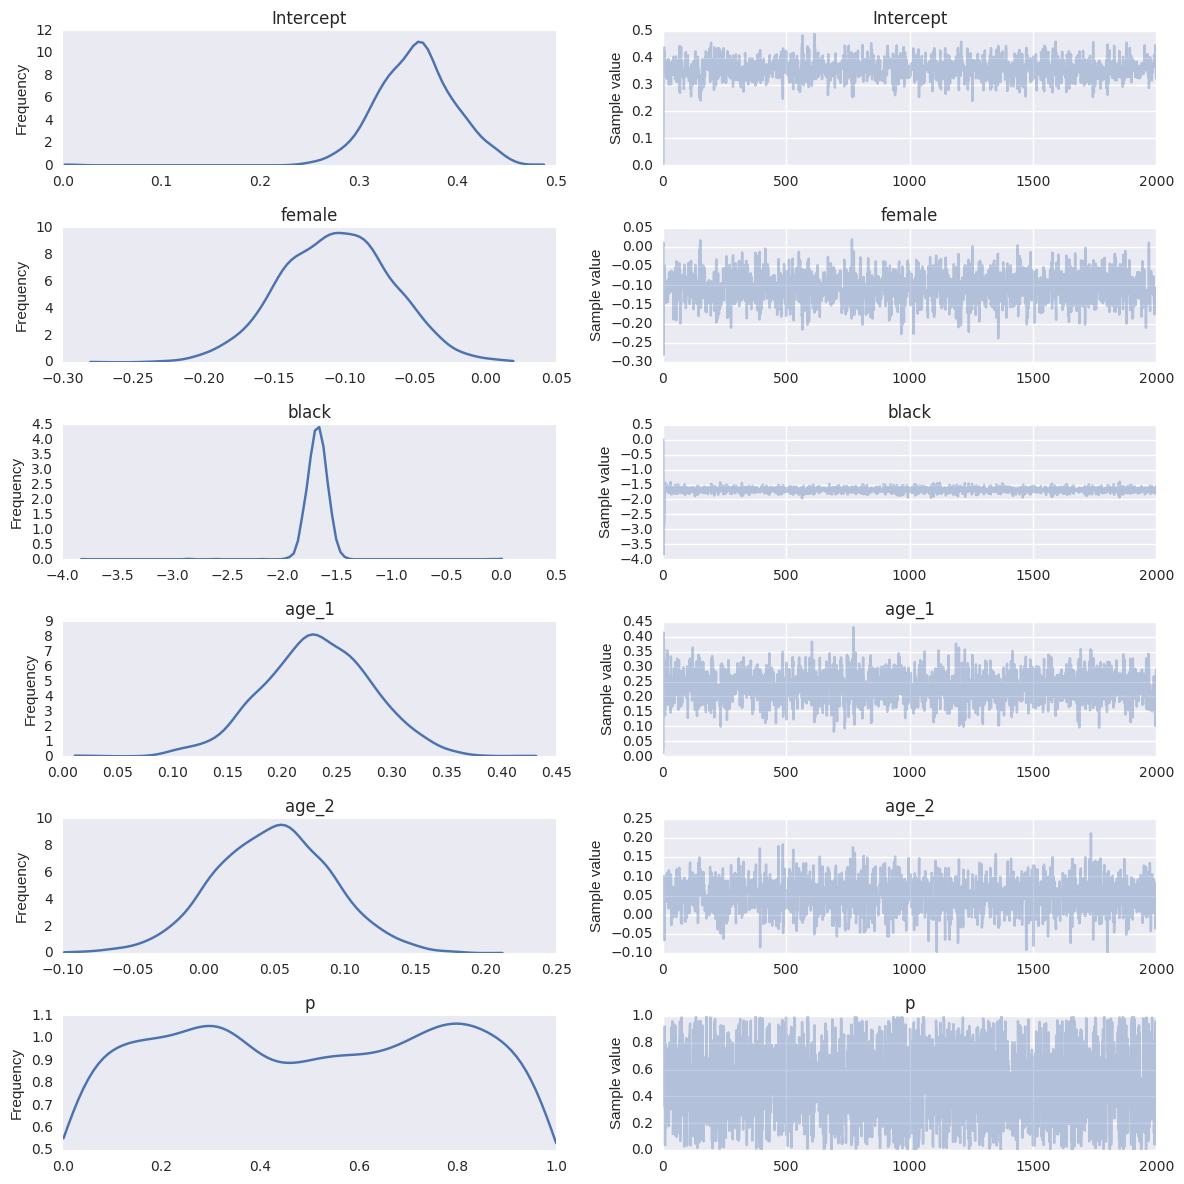

In [25]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace_logistic_model)
plt.tight_layout()

In [27]:
def predict_indiv_model_v2(black, female, age_1, age_2):
    # Returns a series of numbers between 0 and 1 for each run of logistic model
    return 1 / (1 + np.exp(-(trace_logistic_model['Intercept'] +
                        (trace_logistic_model['black'] * black) + 
                        (trace_logistic_model['female'] * female) + 
                        (trace_logistic_model['age_1'] * age_1 +
                        (trace_logistic_model['age_2'] * age_2)))))

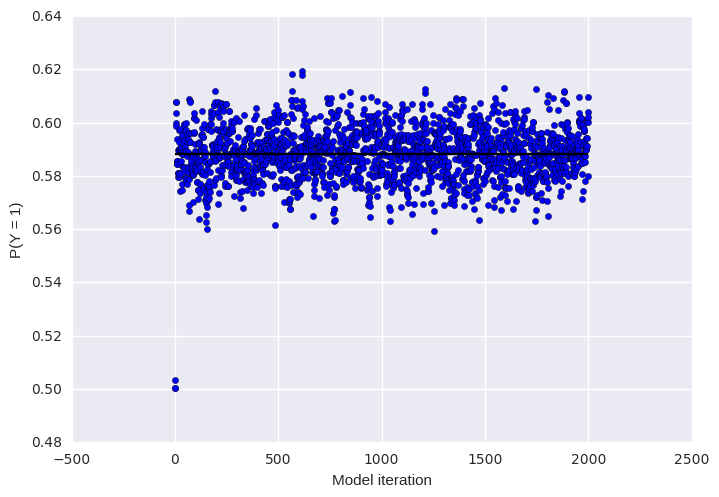

In [29]:
plot_results(predict_indiv_model_v2(0, 0, 0, 0))

In [34]:
def simple_function(*args):
    for item in args:
        print item

simple_function(1, 2, 8, 20, 100)
simple_function({'a': 'Cool', 'b': 'cooler'})
simple_function([1,2,3,4,5], [6,7,8,9,10])

1
2
8
20
100
{'a': 'Cool', 'b': 'cooler'}
[1, 2, 3, 4, 5]
[6, 7, 8, 9, 10]


In [38]:
def predict(dictionary, model):
    coefs = sum([model[key] * value for key, value in dictionary.items()])
    coefs += model['Intercept']
    return 1 / (1 + np.exp(-(coefs)))

In [39]:
sample_person = {
    'black': 0,
    'female': 1,
    'age_1': 0,
    'age_2': 1
}

In [40]:
predict(sample_person, trace_logistic_model)

array([ 0.5013,  0.5013,  0.5091, ...,  0.5762,  0.5654,  0.567 ])

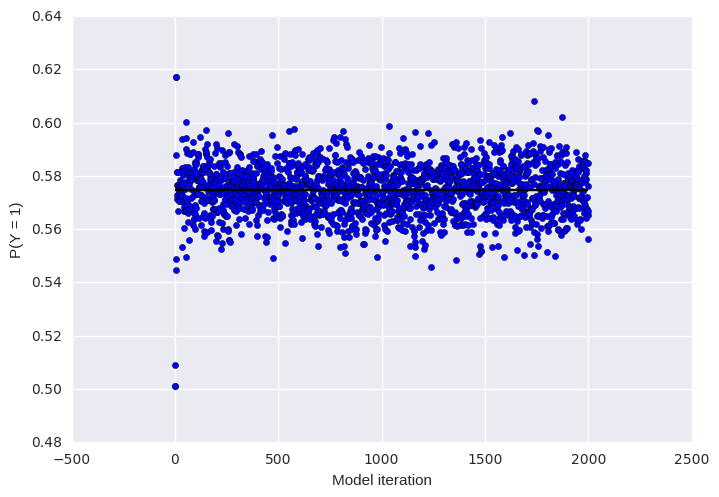

In [41]:
plot_results(predict(sample_person, trace_logistic_model))